In [3]:

import pandas as pd
import xgboost as xgb
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold,train_test_split
from sklearn.metrics import classification_report, accuracy_score


%matplotlib inline

## Data overview

In [4]:
filename = r'C:\Users\Tudor\PycharmProjects\machine_learning\mp2\Telco-Customer-Churn.csv'

data = pd.read_csv(filename)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0


## Data Manipulation

We first have to handle the TotalCharges colum, it contains blank spaces and we have to also transform the data into float values.

In [6]:
# We first have 
#Replacing spaces with null values in total charges column
data['TotalCharges'] = data["TotalCharges"].replace(" ",np.nan)
data = data[data["TotalCharges"].notnull()]
data = data.reset_index()[data.columns]
data["TotalCharges"] = data["TotalCharges"].astype(float)

## Exploratory Data Analytics

In [7]:
id_column     = ['customerID']
target_column = ['Churn']
categorical_features = data.nunique()[data.nunique() < 6].keys().tolist()
categorical_features = [x for x in categorical_features if x not in target_column]

numerical_features   = [x for x in data.columns if x not in categorical_features + target_column + id_column]

binary_columns   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_columns = [i for i in categorical_features if i not in binary_columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017CA4CE92B0>,
      dtype=object)

<Figure size 1008x288 with 0 Axes>

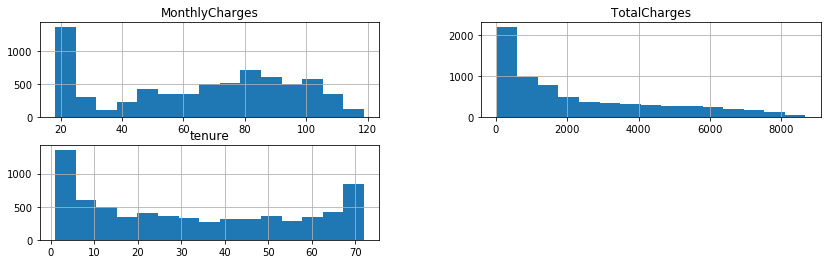

In [8]:
fig, ax = plt.subplots(0, 3, figsize=(14, 4))
data[numerical_features].hist(bins=15, figsize=(14, 4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017CA4D72640>,
      dtype=object)

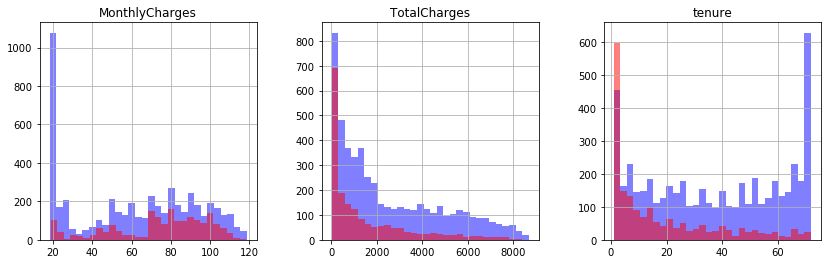

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
data[data.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
data[data.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

Text(0.5, 1.0, 'churned')

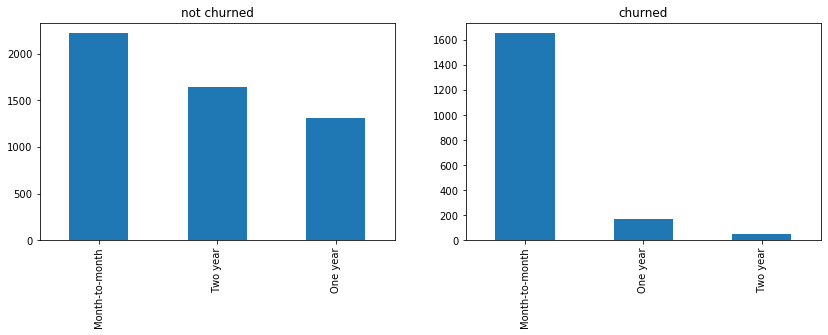

In [10]:
feature = 'Contract'
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
data[data.Churn == "No"][feature].value_counts().plot(kind='bar', ax=ax[0]).set_title('not churned')
data[data.Churn == "Yes"][feature].value_counts().plot(kind='bar', ax=ax[1]).set_title('churned')

Text(0.5, 1.0, 'churned')

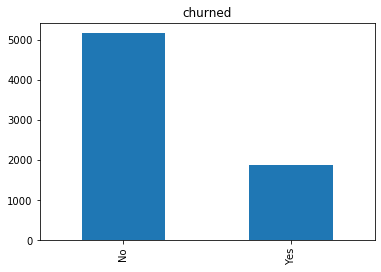

In [11]:
data[target_column[0]].value_counts().plot(kind='bar').set_title('churned')

## Encoding the data

In [12]:
le = LabelEncoder()
for i in binary_columns :
    data[i] = le.fit_transform(data[i])


data = pd.get_dummies(data = data,columns = multi_columns )
std = StandardScaler()
scaled = std.fit_transform(data[numerical_features])
scaled = pd.DataFrame(scaled,columns=numerical_features)

df_data_og = data.copy()
data = data.drop(columns = numerical_features,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [13]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0.064303,-0.260878,-0.173740
2,3668-QPYBK,1,0,0,0,1,1,1,1,0,...,1,0,0,0,0,0,1,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,1,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,0,0,1,1,1,1,0,...,1,0,0,0,0,1,0,-1.239504,0.196178,-0.940457


## Defining the model

In [14]:
# Split the data in input and output
X = data.drop([id_column[0], target_column[0]], axis=1)
y = data[target_column[0]]

In [15]:
# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print("X_train size = ", str(X_train.shape))
print("y_train size = ", str(y_train.shape))

print("X_test size = ", str(X_test.shape))
print("y_test size = ", str(y_test.shape))

X_train size =  (4922, 40)
y_train size =  (4922,)
X_test size =  (2110, 40)
y_test size =  (2110,)


In [16]:
classifier = xgb.XGBClassifier(objective= 'binary:logistic', seed=42, nthread=-1)
classifier.fit(X_train, y_train)

# check the training accuracy using cross validation

s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_cv_scores = cross_val_score(classifier, X_train , y_train, cv=s_kfold )
print("Stratified K-fold CV average score: %.2f" % skf_cv_scores.mean())

Mean cross-validation score: 0.80
Stratified K-fold CV average score: 0.80


In [17]:
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.66      0.51      0.57       561

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110

Accuracy: 0.7985781990521327


## Imbalanced Learn

In [25]:
smt = SMOTETomek(random_state=42)
 
X_res, y_res = smt.fit_resample(X, y)
y_res.value_counts()

In [33]:

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, shuffle=True)
classifier = xgb.XGBClassifier(objective= 'binary:logistic', seed=42, nthread=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

precision    recall  f1-score   support

           0       0.87      0.79      0.83      1493
           1       0.80      0.88      0.84      1458

    accuracy                           0.83      2951
   macro avg       0.83      0.83      0.83      2951
weighted avg       0.84      0.83      0.83      2951

Accuracy: 0.8319213825821755


## GridSearch

# Warning: this should take ~10 min to run

In [34]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  6.8min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:  8.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [38]:
boosted_booster = grid_search.best_estimator_

y_pred = boosted_booster.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

precision    recall  f1-score   support

           0       0.89      0.84      0.86      1493
           1       0.84      0.89      0.86      1458

    accuracy                           0.86      2951
   macro avg       0.86      0.86      0.86      2951
weighted avg       0.86      0.86      0.86      2951

Accuracy: 0.8617417824466282
